In [ ]:
!pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold # k-фолдная валидация
from catboost import CatBoostClassifier

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.express as px

## Функции

In [497]:
# Функция для удаления колонок с пустыми значениями
def drop_nan_column(df: pd.DataFrame, precent=1):
    drop_columns = []
    for column in df.columns:
        c_type = df[column].dtype
        
        if c_type == 'int64' or c_type == 'float64':
            if len(df.loc[(df[column] != 0) & (df[column].isna()==False) , column]) < len(df)*precent:
                drop_columns.append(column)
        
        else:
            if len(df.loc[(df[column].isna()==False) & (df[column] != 'Х'), column]) < len(df)*precent:
                drop_columns.append(column)
    
    df = df.drop(drop_columns, axis=1)
    
    return df, drop_columns

## Загрузка данных

In [498]:
df2019 = pd.read_csv("agents2019.csv", index_col=1)
df2020 = pd.read_csv("agents2020.csv", index_col=0)
df2021 = pd.read_csv("agents2021.csv", index_col=1)

In [499]:
df2019 = df2019.drop(['Unnamed: 0'], axis=1)
df2021 = df2021.drop(['Unnamed: 0'], axis=1)

In [500]:
print(df2019.info())
df2019.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 0 to 530
Data columns (total 53 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Макс. ПДЗ за 2019 год, дней                        531 non-null    int64  
 1   Сред. ПДЗ за 2019 год, дней                        531 non-null    float64
 2   Кол-во просрочек свыше 5-ти дней за 2019 год, шт.  531 non-null    int64  
 3   Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.  531 non-null    float64
 4   Кол-во раз ПДЗ за 2019 год, шт.                    531 non-null    int64  
 5   2016, Нематериальные активы, RUB                   531 non-null    float64
 6   2017, Нематериальные активы, RUB                   531 non-null    float64
 7   2018, Нематериальные активы, RUB                   531 non-null    float64
 8   2016, Основные средства , RUB                      531 non-null    float64
 9   2017, Осно

,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","2016, Нематериальные активы, RUB","2017, Нематериальные активы, RUB","2018, Нематериальные активы, RUB","2016, Основные средства , RUB","2017, Основные средства , RUB",...,"2018, Выручка, RUB","2016, Себестоимость продаж, RUB","2017, Себестоимость продаж, RUB","2018, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB"
count,531.000000,531.000000,531.000000,5.310000e+02,531.000000,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,...,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02
mean,27.743879,7.676839,6.491525,4.825706e+06,17.951036,2.581892e+07,3.600098e+07,4.672202e+07,5.294546e+09,6.206710e+09,...,7.481678e+09,3.478372e+09,4.062224e+09,4.890154e+09,1.395727e+09,1.075368e+09,1.312543e+09,1.054666e+09,1.206979e+09,1.988515e+09
std,111.782987,31.630274,21.681255,1.808713e+07,45.883460,1.933860e+08,3.142319e+08,3.658906e+08,4.984866e+10,5.822300e+10,...,3.150534e+10,1.359011e+10,1.602881e+10,1.852615e+10,9.907869e+09,8.439904e+09,1.193399e+10,7.361247e+09,8.196642e+09,1.271200e+10
min,0.000000,0.000000,0.000000,-2.978865e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.359633e+09,-4.917329e+10,-1.316305e+11,-1.126443e+09,-9.205369e+08,-2.520849e+10
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.121019e+04,2.630573e+05,...,1.684283e+08,3.767293e+07,7.037484e+07,1.573535e+08,4.458599e+04,2.038217e+04,8.356688e+05,0.000000e+00,5.796178e+04,1.482803e+06
50%,3.000000,1.944444,0.000000,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.548790e+07,1.769936e+07,...,5.434306e+08,2.467650e+08,3.284408e+08,4.755548e+08,3.459236e+06,4.535032e+06,6.507006e+06,5.703185e+06,8.603822e+06,1.306624e+07
75%,13.000000,5.072944,3.000000,1.148308e+06,13.000000,9.235669e+03,1.019108e+04,2.707006e+04,1.818576e+08,1.797545e+08,...,2.084913e+09,1.066730e+09,1.400034e+09,1.709260e+09,4.339904e+07,4.402580e+07,5.766210e+07,5.960605e+07,7.043376e+07,8.941911e+07
max,884.000000,608.000000,288.000000,2.477138e+08,451.000000,3.126233e+09,6.320583e+09,7.549618e+09,8.592764e+11,9.379076e+11,...,3.879375e+11,1.516090e+11,1.907341e+11,2.111127e+11,1.237635e+11,1.102105e+11,1.349557e+11,1.393573e+11,1.483514e+11,2.091451e+11


## EDA

In [501]:
# Кол-во пересечения признаков в датасетах
print(len(list(set(df2019.columns) & set(df2020.columns))))
print(len(list(set(df2020.columns) & set(df2021.columns))))
print(len(list(set(df2019.columns) & set(df2021.columns))))

48
72
53


### 2019 год

In [502]:
@interact
def show_boxplot(column=list(df2019.columns)):
    fig = px.histogram(df2019, x=column, 
                       marginal="box", nbins=len(df2019))
    fig.show()

interactive(children=(Dropdown(description='column', options=('Макс. ПДЗ за 2019 год, дней', 'Сред. ПДЗ за 201…

In [503]:
df2019['Факт просрочки'] = 0
df2019.loc[df2019['Кол-во раз ПДЗ за 2019 год, шт.'] > 0 ,'Факт просрочки'] = 1

In [504]:
@interact
def show_boxplot(column=list(df2019.columns)):
    fig = px.box(df2019, x=column, color='Факт просрочки')
    fig.show()

interactive(children=(Dropdown(description='column', options=('Макс. ПДЗ за 2019 год, дней', 'Сред. ПДЗ за 201…

In [505]:
@interact
def show_boxplot(column1=list(df2019.columns), 
                column2=list(df2019.columns),
                column3=list(df2019.columns),
                column4=list(df2019.columns)):
    fig = px.scatter_matrix(df2019,
            dimensions=[column1, column2, column3, column4],
            color='Факт просрочки')
    fig.show()

interactive(children=(Dropdown(description='column1', options=('Макс. ПДЗ за 2019 год, дней', 'Сред. ПДЗ за 20…

In [506]:
@interact
def show_boxplot(column=list(df.columns)):
    fig = px.box(df, x=column, color='Факт просрочки')
    fig.show()

interactive(children=(Dropdown(description='column', options=('Наименование ДП', 'Год', 'Нематериальные активы…

## 2020 год

In [507]:
drop_nan_column(df2020, precent=0.2)

(                Факт. 33 Факт. 49 Факт. 54  Итого  \
 Наименование ДП                                     
 0                      Х       10      Н/Д   10.0   
 1                      Х       10       10   20.0   
 2                      Х       10      Н/Д   40.0   
 3                      Х        Х       10   10.0   
 4                      Х       10       10   20.0   
 ...                  ...      ...      ...    ...   
 526                  Н/Д        Х       10   70.0   
 527                    Х        Х      Н/Д    0.0   
 528                    Х        Х      Н/Д   50.0   
 529                    Х       10        Х   70.0   
 530                    Х       10      Н/Д   10.0   
 
                  Макс. ПДЗ за 2020 год, дней  Сред. ПДЗ за 2020 год, дней  \
 Наименование ДП                                                             
 0                                         10                     6.400000   
 1                                          4                 

In [508]:
fact_columns = get_columns_Fact(df2020)
df2020 = df2020.fillna(0)
for col in fact_columns:
    df2020[col] = df2020[col].apply(prep_Fact)

In [509]:
@interact
def show_boxplot(column=list(df2020.columns)):
    fig = px.histogram(df2020, x=column, 
                       marginal="box", nbins=len(df2020))
    fig.show()

interactive(children=(Dropdown(description='column', options=('Факт. 1', 'Факт. 2', 'Факт. 3', 'Факт. 4', 'Фак…

## 2021 год

In [510]:
@interact
def show_boxplot(column=list(df2021.columns),
                    y_column=list(df2021.columns) ):
    fig = px.histogram(df2021, x=column, 
                       marginal="box", nbins=len(df2021))
    fig1 = px.bar(df2021, x=column, y=y_column)
    fig.show()
    fig1.show()

interactive(children=(Dropdown(description='column', options=('Макс. ПДЗ за 2019 год, дней', 'Сред. ПДЗ за 201…

In [511]:
@interact
def show_boxplot(column=list(df2021.columns) ):
    fig = px.box(df2021, x=column, color='Статус')
    fig.show()

interactive(children=(Dropdown(description='column', options=('Макс. ПДЗ за 2019 год, дней', 'Сред. ПДЗ за 201…

## Новый датасет

In [512]:
# Функция для добавления нового признака Год, и объединение всех статей
def transform_df_year(df: pd.DataFrame, columns_year: list):
    df_list = []
    columns_list = []
    concat_list = []
    i = 1
    for column in df.columns:
        search = re.search("\d\d\d\d, ", column)
        
        if search:
            year = re.search("\d\d\d\d", column).group(0)
            buf = df.loc[:, [column]]
            buf["Год"] = int(year)
            buf = buf.reset_index()
            
            
            new_column = re.sub(r'\d\d\d\d, ', '', column).strip()
            
            buf = buf.rename(columns={column: new_column})
            
            concat_list.append(buf)  
            
            if len(concat_list) == len(columns_year):
                i = 1
                buf_concat = pd.concat(concat_list)
                df_list.append(buf_concat)
                concat_list = []
            

            columns_list.append(column)
    full = reduce(lambda x, y: pd.merge(x, y, on = ['Наименование ДП', 'Год'], how='outer'), df_list)
    return full

In [513]:
# Функция для добавления нового признака Год, и объединение всех статей по иномк правилу 
def transform_df_year2(df: pd.DataFrame):
    df_list = []
    columns_list = []
    concat_list = []
    merge_list = []
    i = 1
    for column in df.columns:
        search = re.search(" \d\d\d\d ", column)
        
        if search:
            year = re.search("\d\d\d\d", column).group(0)
            buf = df.loc[:, [column]]
            buf["Год"] = int(year)
            buf = buf.reset_index()
            
            
            new_column = re.sub(r' \d\d\d\d ', ' ', column).strip()
            
            buf = buf.rename(columns={column: new_column})
            
            merge_list.append(buf) 
            if len(merge_list) == 5:
                print(column)
                i=1
                buf_merge = reduce(lambda x, y: pd.merge(x, y, on = ['Наименование ДП', 'Год'], how='outer'), merge_list)
                df_list.append(buf_merge)
                merge_list = []
            
            
            columns_list.append(column)
    full = pd.concat(df_list)
    #full = reduce(lambda x, y: x.join(x, y, on = 'Год', how='outer'), df_list)
    return full

In [514]:
# Образование нового датасета
full = pd.concat([df2021, 
                  df2020,
                  df2019])
full = full[~full.index.duplicated(keep='first')]
full = full.fillna(0)

new_columns = ['Нематериальные активы, RUB', 
                                       'Основные средства , RUB', 'Внеоборотные активы, RUB',
                                       'Дебиторская задолженность, RUB', 'Оборотные активы, RUB',
                                       'Уставный капитал , RUB', 'Капитал и резервы, RUB',
                                       'Заёмные средства (долгосрочные), RUB',
                                       'Долгосрочные обязательства, RUB',
                                       'Заёмные средства (краткосрочные), RUB',
                                       'Кредиторская задолженность, RUB', 'Краткосрочные обязательства, RUB',
                                       'Выручка, RUB', 'Себестоимость продаж, RUB',
                                       'Прибыль (убыток) до налогообложения , RUB',
                                       'Прибыль (убыток) от продажи, RUB']


new_df = transform_df_year(full, [2016,2017,2018,2019,2020])
new_df.loc[:, new_columns] = new_df.loc[:, new_columns]
new_df['Итого Фин'] = new_df.loc[:, new_columns].sum(axis=1)

new_df = pd.merge(new_df, transform_df_year2(full), on = ['Наименование ДП', 'Год'], how='outer')

Кол-во раз ПДЗ за 2019 год, шт.
Кол-во раз ПДЗ за 2020 год, шт.


In [515]:
new_df

,Наименование ДП,"Нематериальные активы, RUB",Год,"Основные средства , RUB","Внеоборотные активы, RUB","Дебиторская задолженность, RUB","Оборотные активы, RUB","Уставный капитал , RUB","Капитал и резервы, RUB","Заёмные средства (долгосрочные), RUB",...,"Выручка, RUB","Себестоимость продаж, RUB","Прибыль (убыток) до налогообложения , RUB","Прибыль (убыток) от продажи, RUB",Итого Фин,"Макс. ПДЗ за год, дней","Сред. ПДЗ за год, дней","Кол-во просрочек свыше 5-ти дней за год, шт.","Общая сумма ПДЗ свыше 5-ти дней за год, руб.","Кол-во раз ПДЗ за год, шт."
0,0,2.895541e+06,2016,1.889724e+09,1.928685e+09,3.583766e+09,5.159380e+09,6.294000e+08,2.673020e+09,0.000000e+00,...,2.667698e+10,2.156814e+10,3.179697e+09,3.280355e+09,7.906715e+10,NaN,NaN,NaN,NaN,NaN
1,2,2.468153e+06,2016,9.698064e+08,9.732745e+08,2.814675e+08,1.286917e+09,1.964459e+07,2.110425e+09,0.000000e+00,...,2.786577e+09,2.038076e+09,5.026662e+08,4.148586e+08,1.161842e+10,NaN,NaN,NaN,NaN,NaN
2,4,5.503185e+05,2016,2.633161e+10,1.114042e+11,4.541817e+09,8.228872e+09,5.955414e+05,1.488038e+10,6.235247e+10,...,4.716934e+10,1.950167e+10,7.163980e+10,2.338912e+10,5.355307e+11,NaN,NaN,NaN,NaN,NaN
3,5,1.364968e+07,2016,3.545236e+10,3.584426e+10,3.929729e+09,2.610407e+10,1.983439e+06,5.154027e+10,4.990871e+09,...,2.388466e+10,8.572090e+09,9.990124e+09,1.149385e+10,2.265287e+11,NaN,NaN,NaN,NaN,NaN
4,6,5.898089e+05,2016,1.012790e+10,4.768094e+10,5.114850e+09,1.943818e+10,2.717197e+06,6.494965e+09,4.546148e+10,...,5.066868e+10,3.692988e+10,2.294589e+10,1.029108e+10,3.299521e+11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,521,0.000000e+00,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0,3.0,0.0,0.000000,2.0
2651,524,0.000000e+00,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,13.0,5.0,1.0,378264.751592,4.0
2652,526,0.000000e+00,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0
2653,529,0.000000e+00,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0


In [516]:
# Отображение факта просрочки в этом году
new_df['Факт просрочки'] = 0
new_df.loc[new_df['Кол-во раз ПДЗ за год, шт.'] > 0 ,'Факт просрочки'] = 1

In [517]:
# Добавление признаков с 2021 год по ПДЗ
new_df2021 = df2021.loc[:,[ 'Оценка потенциала контрагента 1, руб.',
                            'Оценка потенциала контрагента 2, руб.', 'Статус',
                          'Итого',
                           'ПДЗ 1-30', 'ПДЗ 31-90', 'ПДЗ 91-365', 'ПДЗ более 365']].copy()
new_df2021['Факт просрочки'] = 0
new_df2021.loc[new_df2021[['ПДЗ 1-30', 'ПДЗ 31-90', 'ПДЗ 91-365', 'ПДЗ более 365']].sum(axis=1) > 0 ,'Факт просрочки'] = 1

new_df2021['Год'] = 2021


In [518]:
new_df = pd.concat([new_df, new_df2021.reset_index()])

In [519]:
new_df.to_excel('transform_data2.xlsx')

## Machine learning

In [325]:
df = pd.read_excel('transform_data2.xlsx')

In [326]:
# Убираем тех контрагентов, у которых совсем нет данных за год
df = df.loc[df['Итого Фин'] > 0, :]

In [327]:
# Оставляем данные за два года, так как только за эти года у нас есть финансовые показатели и 
# данные о просрочке
df = df.loc[(df['Год'] >= 2019) & (df['Год'] <= 2020), :]

<AxesSubplot:>

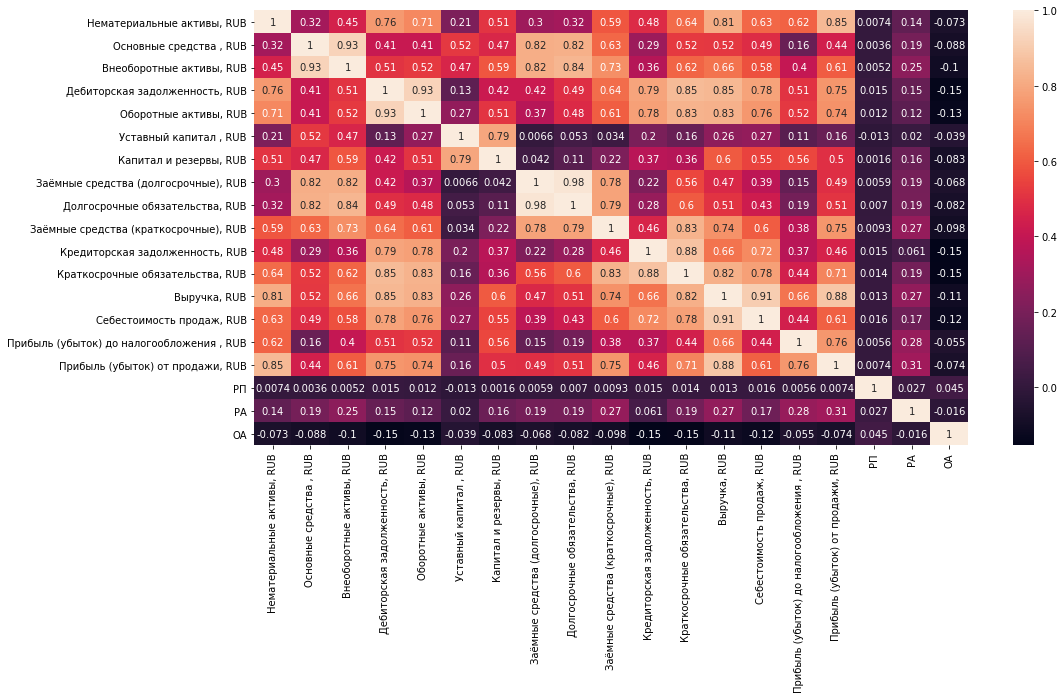

In [478]:
plt.figure(figsize=(16, 8)) 
sns.heatmap(df.loc[:,['Нематериальные активы, RUB', 
               'Основные средства , RUB', 
            'Внеоборотные активы, RUB',
               'Дебиторская задолженность, RUB', 'Оборотные активы, RUB',
               'Уставный капитал , RUB', 'Капитал и резервы, RUB',
               'Заёмные средства (долгосрочные), RUB',
               'Долгосрочные обязательства, RUB',
               'Заёмные средства (краткосрочные), RUB',
               'Кредиторская задолженность, RUB', 'Краткосрочные обязательства, RUB',
               'Выручка, RUB', 'Себестоимость продаж, RUB',
               'Прибыль (убыток) до налогообложения , RUB',
               'Прибыль (убыток) от продажи, RUB',
                 'РП', 'РА', 'ОА']].corr(), annot=True,)

In [328]:
# Расчет новых признаков
# Рентабельность продаж
df['РП'] = (df['Прибыль (убыток) от продажи, RUB'] / (df['Выручка, RUB']+1)).fillna(0) #РП = Чистая прибыль / Выручка * 100 %

# Рентабельность активов
df['РА'] = (df['Прибыль (убыток) от продажи, RUB'] / (df['Оборотные активы, RUB']+1)).fillna(0) # Прибыль за период / Средняя величина активов за этот же период * 100 %

# Оборачиваемость активов
df['ОА'] = (df['Выручка, RUB'] / (df['Оборотные активы, RUB'] + df['Внеоборотные активы, RUB']+1)).fillna(0) # ОА = Выручка за период / Стоимость активов за период

In [330]:
# Формирование датасета с допольнительными данными
# Данные брались с сайта Росстата
dop = pd.DataFrame({
    'Год': [2019, 2020],
    'Курс доллара, RUB': [62.60, 64.7362],#71.94],
    'Инфляция, %':[4.2,3.8],# 3.],
    'Безработица, %': [4.8, 4.4],# 5.9],
    'ВВП': [103, 109 ]
})
# Все показатели на начало данного переиода или конец предыдущего
dop

In [331]:
# Объединяем датасеты
df = pd.merge(df, dop, how='left', on='Год')

Опираясь на корреляцию между признаками, было принято решение, убрать 'Оборотные активы, RUB', 'Долгосрочные обязательства, RUB', 'Выручка, RUB', что позволило улучшить метрики качества классификации 

In [521]:
# Подготовка данных для загрузки в модель
X = df.loc[:,['Нематериальные активы, RUB', 
               'Основные средства , RUB', 
            'Внеоборотные активы, RUB',
               'Дебиторская задолженность, RUB', #'Оборотные активы, RUB',
               'Уставный капитал , RUB', 'Капитал и резервы, RUB',
               'Заёмные средства (долгосрочные), RUB',
               #'Долгосрочные обязательства, RUB',
               'Заёмные средства (краткосрочные), RUB',
               'Кредиторская задолженность, RUB', 'Краткосрочные обязательства, RUB',
              # 'Выручка, RUB', 
              'Себестоимость продаж, RUB',
               'Прибыль (убыток) до налогообложения , RUB',
               'Прибыль (убыток) от продажи, RUB',
                 'РП', 'РА', 'ОА'] + list(dop.columns)[1:] ]

y = df.loc[:, 'Факт просрочки']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

После некоторых тестов мы остановились на алгоритмах, реализованных в Catboost

In [522]:
# Настройка гиперпараметров
catboost_params = { 'iterations' : 100, 'depth' : 8,
                    'random_seed' : 42,
                   'loss_function' : 'Logloss','eval_metric' : 'F1',
                   'boosting_type' : 'Plain','bootstrap_type' : 'MVS',
                   'task_type' : 'CPU'}

In [523]:
# Обучение
clf = CatBoostClassifier(**catboost_params )
clf.fit(X_train, y_train)

Learning rate set to 0.071862
0:	learn: 0.6677215	total: 3.95ms	remaining: 391ms
1:	learn: 0.6444073	total: 6.9ms	remaining: 338ms
2:	learn: 0.6763285	total: 42.9ms	remaining: 1.39s
3:	learn: 0.6848875	total: 86ms	remaining: 2.06s
4:	learn: 0.6816720	total: 123ms	remaining: 2.33s
5:	learn: 0.7038217	total: 166ms	remaining: 2.59s
6:	learn: 0.6987179	total: 197ms	remaining: 2.62s
7:	learn: 0.6818182	total: 203ms	remaining: 2.33s
8:	learn: 0.6796748	total: 238ms	remaining: 2.4s
9:	learn: 0.7083333	total: 268ms	remaining: 2.42s
10:	learn: 0.7147436	total: 300ms	remaining: 2.43s
11:	learn: 0.7261146	total: 325ms	remaining: 2.38s
12:	learn: 0.7344992	total: 370ms	remaining: 2.47s
13:	learn: 0.7503925	total: 411ms	remaining: 2.52s
14:	learn: 0.7635240	total: 449ms	remaining: 2.55s
15:	learn: 0.7885196	total: 474ms	remaining: 2.49s
16:	learn: 0.7951807	total: 497ms	remaining: 2.43s
17:	learn: 0.7933635	total: 500ms	remaining: 2.28s
18:	learn: 0.7981928	total: 524ms	remaining: 2.23s
19:	learn: 

In [524]:
# Оценка качества 
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        82
           1       0.70      0.68      0.69        87

    accuracy                           0.69       169
   macro avg       0.69      0.69      0.69       169
weighted avg       0.69      0.69      0.69       169

ROC-AUC: 0.6866414353798709


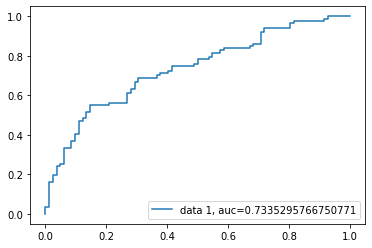

In [525]:
# График ROC-AUC
y_pred_proba = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Как видно выше, метрики классификации показывают среднюю предсказательную способность

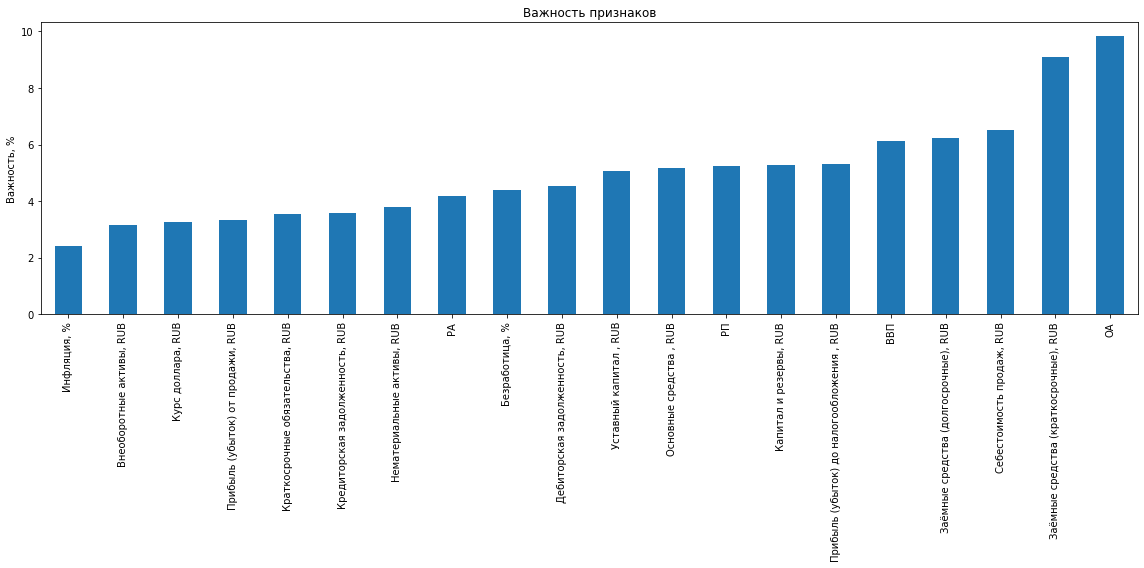

In [526]:
# Важность признаков
cat_imp = pd.Series(clf.get_feature_importance(),
                         X.columns).sort_values()
fig, ax = plt.subplots(figsize=(16,8))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()